In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
batch_size = 40
img_height = 200
img_width = 200

Keras dataset preprocessing utilities, located at tf.keras.preprocessing, help you go from raw data on disk to a tf.data.Dataset object that can be used to train a model.

See https://keras.io/api/preprocessing/

Once the dataset is preprocessed and loaded, it can be directly used in calls to model.fit



In [3]:
## loading training data
training_ds = tf.keras.preprocessing.image_dataset_from_directory(
    'data/MaskNoMask/data',
    validation_split=0.2,
    subset= "training",
    seed=42,
    image_size= (img_height, img_width),
    batch_size=batch_size

)

Found 7553 files belonging to 2 classes.
Using 6043 files for training.


In [4]:
## loading testing data
testing_ds = tf.keras.preprocessing.image_dataset_from_directory(
'data/MaskNoMask/data',
    validation_split=0.2,
    subset= "validation",
    seed=42,
    image_size= (img_height, img_width),
    batch_size=batch_size

)

Found 7553 files belonging to 2 classes.
Using 1510 files for validation.


In [5]:
training_ds

<BatchDataset shapes: ((None, 200, 200, 3), (None,)), types: (tf.float32, tf.int32)>

In [6]:
class_names = training_ds.class_names

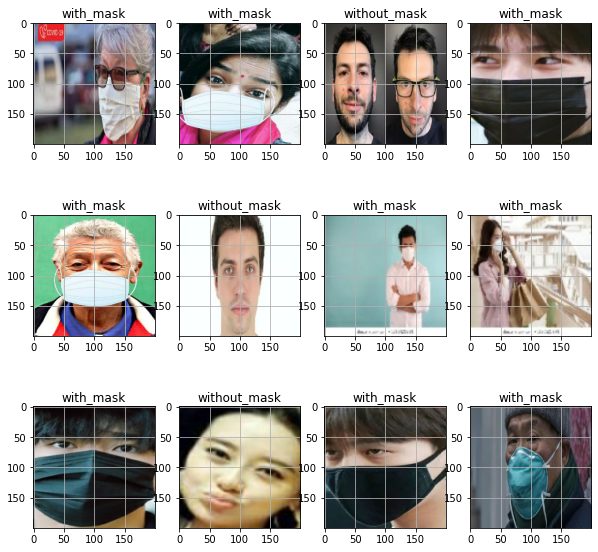

In [7]:
plt.figure(figsize=(10, 10))
for images, labels in training_ds.take(1):
  for i in range(12):
    ax = plt.subplot(3, 4, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.grid(True)

In [14]:
from keras.models import Model
from keras.layers import Input, Dense, Activation, Conv2D, MaxPooling2D, Flatten, BatchNormalization, Dropout
from keras.datasets import mnist
from keras.optimizers import Adam
from keras.applications.resnet50 import ResNet50
from keras import applications
from keras.preprocessing import image
from keras.applications.resnet50 import preprocess_input, decode_predictions

from sklearn.metrics import classification_report, confusion_matrix

In [9]:
## Configuring dataset for performance
AUTOTUNE = tf.data.experimental.AUTOTUNE
training_ds = training_ds.cache().prefetch(buffer_size=AUTOTUNE)
testing_ds = testing_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Now build a deep neural network and train it and see how you do

Starting with examples from keras docs found here
 
 https://keras.io/examples/vision/image_classification_from_scratch/

In [71]:
inputs = Input(shape=(200, 200, 3))


x = layers.experimental.preprocessing.Rescaling(1.0 / 255)(x)
x = layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)

x = layers.Conv2D(64, 3, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)

previous_block_activation = x  # Set aside residual



x = layers.Dropout(0.25)(x)
x = layers.Activation("relu")(x)
x = layers.SeparableConv2D(150, 3, padding="same")(x)
x = layers.BatchNormalization()(x)

x = layers.Activation("relu")(x)
x = layers.SeparableConv2D(150, 3, padding="same")(x)
x = layers.BatchNormalization()(x)

x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

# Project residual
residual = layers.Conv2D(150, 1, strides=2, padding="same")(
    previous_block_activation
)
x = layers.add([x, residual])  # Add back residual
previous_block_activation = x  # Set aside next residual




x = layers.Dropout(0.25)(x)
x = layers.Activation("relu")(x)
x = layers.SeparableConv2D(300, 3, padding="same")(x)
x = layers.BatchNormalization()(x)

x = layers.Activation("relu")(x)
x = layers.SeparableConv2D(300, 3, padding="same")(x)
x = layers.BatchNormalization()(x)

x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

# Project residual
residual = layers.Conv2D(300, 1, strides=2, padding="same")(
    previous_block_activation
)
x = layers.add([x, residual])  # Add back residual
previous_block_activation = x  # Set aside next residual




x = layers.Dropout(0.25)(x)
x = layers.Activation("relu")(x)
x = layers.SeparableConv2D(500, 3, padding="same")(x)
x = layers.BatchNormalization()(x)

x = layers.Activation("relu")(x)
x = layers.SeparableConv2D(500, 3, padding="same")(x)
x = layers.BatchNormalization()(x)

x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

# Project residual
residual = layers.Conv2D(500, 1, strides=2, padding="same")(
    previous_block_activation
)
x = layers.add([x, residual])  # Add back residual
previous_block_activation = x  # Set aside next residual




x = layers.Activation("relu")(x)
x = layers.SeparableConv2D(800, 3, padding="same")(x)
x = layers.BatchNormalization()(x)

x = layers.Activation("relu")(x)
x = layers.SeparableConv2D(800, 3, padding="same")(x)
x = layers.BatchNormalization()(x)

x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

# Project residual
residual = layers.Conv2D(800, 1, strides=2, padding="same")(
    previous_block_activation
)
x = layers.add([x, residual])  # Add back residual
previous_block_activation = x  # Set aside next residual




x = layers.Activation("relu")(x)
x = layers.SeparableConv2D(1000, 3, padding="same")(x)
x = layers.BatchNormalization()(x)

x = layers.Activation("relu")(x)
x = layers.SeparableConv2D(1000, 3, padding="same")(x)
x = layers.BatchNormalization()(x)

x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

# Project residual
residual = layers.Conv2D(1000, 1, strides=2, padding="same")(
    previous_block_activation
)
x = layers.add([x, residual])  # Add back residual
previous_block_activation = x  # Set aside next residual




x = layers.SeparableConv2D(1024, 3, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)

x = layers.GlobalAveragePooling2D()(x)
activation = "sigmoid"
units = 1

x = layers.Dropout(0.5)(x)
outputs = layers.Dense(units, activation=activation)(x)

model = Model(inputs=inputs, outputs=outputs)
model.summary()

Model: "functional_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 200, 200, 3) 0                                            
__________________________________________________________________________________________________
conv2d_16 (Conv2D)              (None, 100, 100, 32) 896         input_4[0][0]                    
__________________________________________________________________________________________________
batch_normalization_29 (BatchNo (None, 100, 100, 32) 128         conv2d_16[0][0]                  
__________________________________________________________________________________________________
activation_29 (Activation)      (None, 100, 100, 32) 0           batch_normalization_29[0][0]     
_______________________________________________________________________________________

In [72]:
model.compile(
    optimizer=Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)

model.fit(
    training_ds, epochs=3, validation_data=testing_ds,
)

Epoch 1/3
152/152 [==============================] - 92s 605ms/step - loss: 0.3378 - accuracy: 0.8535 - val_loss: 0.6817 - val_accuracy: 0.5636
Epoch 2/3
152/152 [==============================] - 92s 606ms/step - loss: 0.1838 - accuracy: 0.9285 - val_loss: 0.8634 - val_accuracy: 0.5086
Epoch 3/3
152/152 [==============================] - 92s 605ms/step - loss: 0.1384 - accuracy: 0.9490 - val_loss: 0.4202 - val_accuracy: 0.7808


In [74]:
model.fit(
    training_ds, epochs=5, validation_data=testing_ds,
)

Epoch 1/5
152/152 [==============================] - 92s 605ms/step - loss: 0.0500 - accuracy: 0.9808 - val_loss: 0.1765 - val_accuracy: 0.9424
Epoch 2/5
152/152 [==============================] - 92s 606ms/step - loss: 0.0405 - accuracy: 0.9858 - val_loss: 2.5088 - val_accuracy: 0.6735
Epoch 3/5
152/152 [==============================] - 93s 613ms/step - loss: 0.0441 - accuracy: 0.9825 - val_loss: 0.0884 - val_accuracy: 0.9709
Epoch 4/5
152/152 [==============================] - 94s 615ms/step - loss: 0.0261 - accuracy: 0.9911 - val_loss: 0.1586 - val_accuracy: 0.9477
Epoch 5/5
152/152 [==============================] - 93s 615ms/step - loss: 0.0337 - accuracy: 0.9889 - val_loss: 0.2223 - val_accuracy: 0.9351


In [75]:

Y_pred = model.predict(testing_ds)
y_pred = [1 * (x[0]>=0.5) for x in Y_pred]
y_true = np.concatenate([y for x, y in testing_ds], axis=0)

In [76]:
print(confusion_matrix(y_true, y_pred))
print(classification_report(y_true, y_pred))

[[725  17]
 [ 81 687]]
              precision    recall  f1-score   support

           0       0.90      0.98      0.94       742
           1       0.98      0.89      0.93       768

    accuracy                           0.94      1510
   macro avg       0.94      0.94      0.94      1510
weighted avg       0.94      0.94      0.94      1510



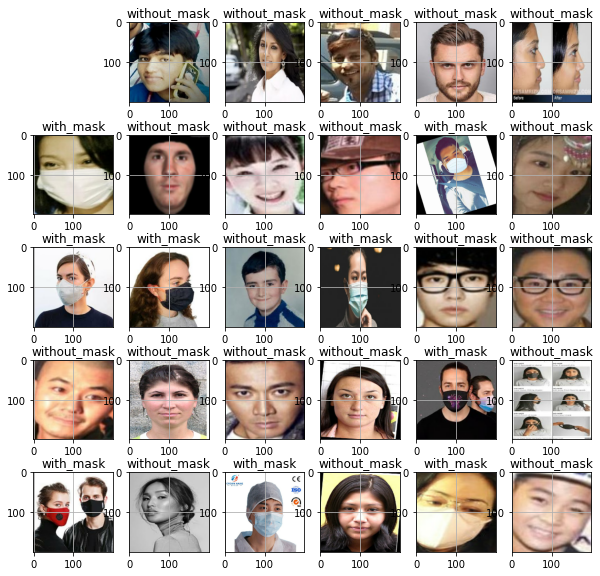

In [77]:

# Print out ones we didn't get right
plt.figure(figsize=(10, 10))

count = 0
good = 0
for images, labels in testing_ds.take(200):
    for i in range(40):
        count = count + 1        
        if y_true[i] == y_pred[i]:
            continue
        good = good + 1
        if good > 29:
            break
        ax = plt.subplot(5, 6, good + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.grid(True)
